In [20]:
#Importing Libraries
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [21]:
count = 0  # Variabel untuk menghitung total jumlah gambar
dirs = os.listdir('Images/')  # Mendapatkan daftar direktori di dalam folder 'Images/'
for dir in dirs:  # Melakukan iterasi untuk setiap direktori di dalam folder 'Images/'
    files = list(os.listdir('Images/'+dir))  # Mendapatkan daftar file di dalam setiap direktori
    print( dir +' Folder has '+ str(len(files)) + ' Images')  # Mencetak jumlah gambar di setiap direktori
    count = count + len(files)  # Menambahkan jumlah gambar di setiap direktori ke dalam total count
print( 'Images Folder has '+ str(count) + ' Images')  # Mencetak total jumlah gambar di folder 'Images/'


daisy Folder has 545 Images
dandelion Folder has 736 Images
rose Folder has 494 Images
sunflower Folder has 446 Images
tulip Folder has 606 Images
Images Folder has 2827 Images


In [22]:
base_dir = 'Images/'  # Menyimpan direktori utama di mana gambar-gambar disimpan
img_size = 180  # Menyimpan ukuran gambar yang akan digunakan dalam proses pemrosesan
batch = 32  # Menyimpan ukuran batch yang akan digunakan dalam proses pembelajaran model

In [23]:
# untuk memuat dataset gambar dari direktori yang diberikan dan membaginya menjadi subset pelatihan dan validasi
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 2827 files belonging to 5 classes.
Using 2262 files for training.
Found 2827 files belonging to 5 classes.
Using 565 files for validation.


In [24]:
#mendapatkan nama kelas atau label dari dataset gambar
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [25]:
import matplotlib.pyplot as plt

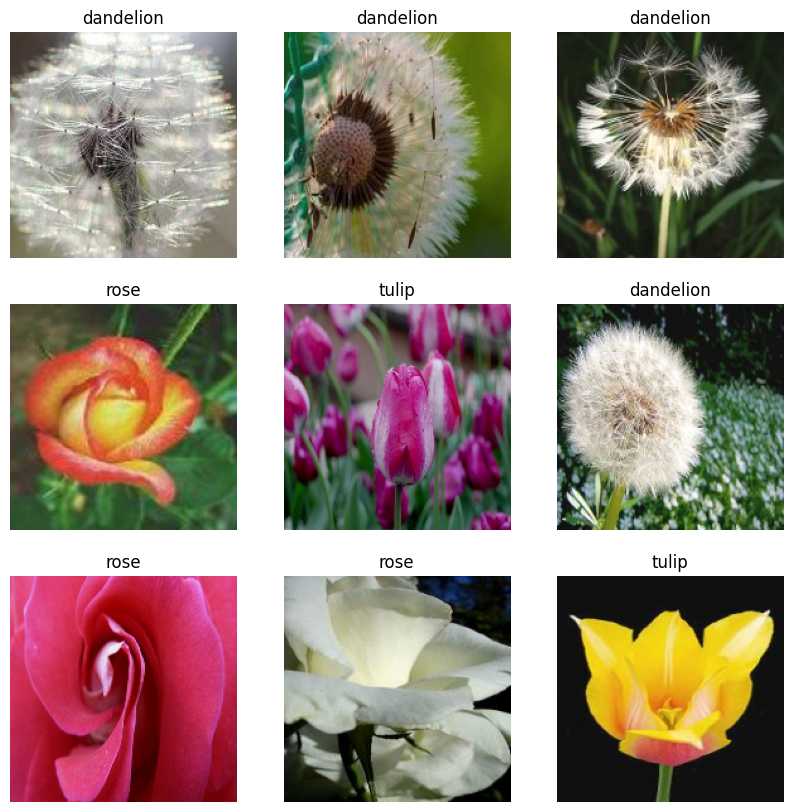

In [26]:
i = 0 
plt.figure(figsize=(10,10))  # Membuat gambar baru dengan ukuran 10x10 inci

# Mengambil satu batch gambar dan label dari dataset pelatihan
for images, labels in train_ds.take(1):
    # Iterasi melalui gambar-gambar dalam batch
    for i in range(9):
        # Menampilkan gambar dalam grid 3x3
        plt.subplot(3,3, i+1)  # Membuat subplot pada grid 3x3, indeks dimulai dari 1
        plt.imshow(images[i].numpy().astype('uint8'))  # Menampilkan gambar dalam format numpy
        plt.title(flower_names[labels[i]])  # Menambahkan judul berdasarkan nama kelas
        plt.axis('off')  # Menghilangkan sumbu x dan y pada gambar


In [27]:
# Jumlah thread yang akan disesuaikan secara otomatis oleh TensorFlow
AUTOTUNE = tf.data.AUTOTUNE  

In [28]:
# Mengoptimalkan dataset pelatihan untuk kinerja yang lebih baik
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [29]:
# Mengoptimalkan dataset validasi untuk kinerja yang lebih baik
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [30]:
# Augmentasi data untuk meningkatkan variasi dalam dataset pelatihan
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

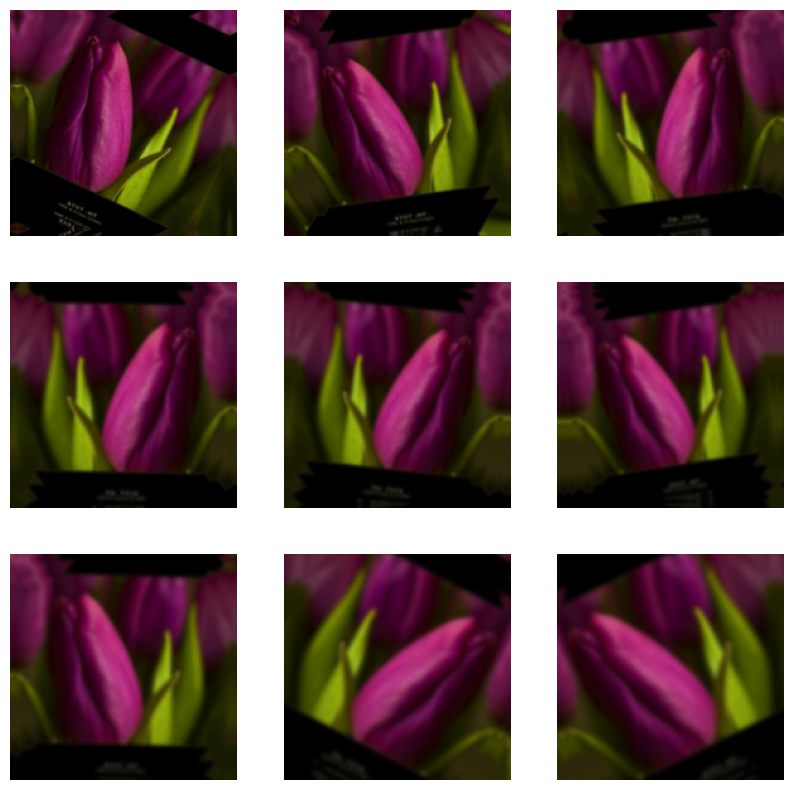

In [31]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [32]:
# Membuat model jaringan saraf konvolusi (CNN) dengan lapisan-lapisan yang didefinisikan
model = Sequential([
    data_augmentation,                      # Lapisan augmentasi data
    layers.Rescaling(1./255),               # Lapisan rescaling untuk normalisasi
    Conv2D(16, 3, padding='same', activation='relu'),    # Lapisan konvolusi dengan 16 filter
    MaxPooling2D(),                         # Lapisan max pooling
    Conv2D(32, 3, padding='same', activation='relu'),    # Lapisan konvolusi dengan 32 filter
    MaxPooling2D(),                         # Lapisan max pooling
    Conv2D(64, 3, padding='same', activation='relu'),    # Lapisan konvolusi dengan 64 filter
    MaxPooling2D(),                         # Lapisan max pooling
    Dropout(0.2),                           # Lapisan dropout dengan dropout rate 0.2
    Flatten(),                             # Lapisan flatten untuk mengubah matriks menjadi vektor
    Dense(128, activation='relu'),          # Lapisan dense dengan 128 unit dan aktivasi ReLU
    Dense(5)                                # Lapisan dense output dengan 5 unit untuk klasifikasi
])


In [33]:
# Mengompilasi model dengan pengoptimal 'adam', fungsi kerugian 'SparseCategoricalCrossentropy', dan metrik 'accuracy'
model.compile(optimizer='adam',                                     # Pengoptimal Adam
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),   # Fungsi kerugian SparseCategoricalCrossentropy
              metrics=['accuracy'])                                  # Metrik akurasi untuk evaluasi model

In [34]:
#menampilkan ringkasan dari arsitektur model CNN 
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [39]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
71/71 [==============================] - 85s 1s/step - loss: 0.4118 - accuracy: 0.8448 - val_loss: 0.4672 - val_accuracy: 0.8336
Epoch 2/15
71/71 [==============================] - 83s 1s/step - loss: 0.3719 - accuracy: 0.8550 - val_loss: 0.4597 - val_accuracy: 0.8513
Epoch 3/15
71/71 [==============================] - 88s 1s/step - loss: 0.3241 - accuracy: 0.8824 - val_loss: 0.4225 - val_accuracy: 0.8460
Epoch 4/15
71/71 [==============================] - 88s 1s/step - loss: 0.2858 - accuracy: 0.8912 - val_loss: 0.5303 - val_accuracy: 0.8088
Epoch 5/15
71/71 [==============================] - 89s 1s/step - loss: 0.3154 - accuracy: 0.8806 - val_loss: 0.5007 - val_accuracy: 0.8319
Epoch 6/15
71/71 [==============================] - 88s 1s/step - loss: 0.2316 - accuracy: 0.9164 - val_loss: 0.3792 - val_accuracy: 0.8708
Epoch 7/15
71/71 [==============================] - 98s 1s/step - loss: 0.2467 - accuracy: 0.9089 - val_loss: 0.3994 - val_accuracy: 0.8655
Epoch 8/15
71/71 [==

In [36]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = np.expand_dims(input_image_array, 0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    flower_name = flower_names[np.argmax(result)]
    confidence_score = np.max(result) * 100
    outcome = f"Hasil klasifikasi: {flower_name}, Akurasi: {confidence_score:.2f}%"
    return outcome


In [37]:
classify_images('Images/daisy/daisy.jpg')

1/1 [==============================] - 0s 207ms/step


'Hasil klasifikasi: daisy, Akurasi: 98.01%'

In [38]:
model.save('final_lab.h5')